<a href="https://colab.research.google.com/github/eiffelwong1/feature-type-inference-using-AL/blob/main/colab_notebooks/Project_234_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install modAL

In [2]:
import os
import csv
import pickle
import pandas as pd
import numpy as np
from functools import partial

import tensorflow as tf
from tensorflow import keras

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from modAL.models import ActiveLearner
from modAL.batch import uncertainty_batch_sampling

import matplotlib.pyplot as plt
%matplotlib inline

import warnings

In [3]:
from google.colab import drive
drive.mount('/content/drive')

xtrain = pd.read_csv('/content/drive/My Drive/Project_234/data_train.csv')
xtest = pd.read_csv('/content/drive/My Drive/Project_234/data_test.csv')

print(xtrain.shape)
print(xtest.shape)
print(xtrain.columns)

Mounted at /content/drive
(7936, 33)
(1985, 33)
Index(['Record_id', 'Attribute_name', 'y_act', 'total_vals', 'num_nans',
       '%_nans', 'num_of_dist_val', '%_dist_val', 'mean', 'std_dev', 'min_val',
       'max_val', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5',
       'has_delimiters', 'has_url', 'has_email', 'has_date', 'mean_word_count',
       'std_dev_word_count', 'mean_stopword_total', 'stdev_stopword_total',
       'mean_char_count', 'stdev_char_count', 'mean_whitespace_count',
       'stdev_whitespace_count', 'mean_delim_count', 'stdev_delim_count',
       'is_list', 'is_long_sentence'],
      dtype='object')


In [4]:
filePathName = '/content/drive/My Drive/Project_234/RandomForest.pkl'
loaded_model = pickle.load(open(filePathName, 'rb'))

In [5]:
useStats = 1
useAttributeName = 1
useSample1 = 0
useSample2 = 0
## Using descriptive stats and attribute name

In [6]:
dict_label = {
    'numeric': 0,
    'categorical': 1,
    'datetime': 2,
    'sentence': 3,
    'url': 4,
    'embedded-number': 5,
    'list': 6,
    'not-generalizable': 7,
    'context-specific': 8
}

y_train = xtrain.loc[:,['y_act']]
y_test = xtest.loc[:,['y_act']]
y_train['y_act'] = [dict_label[i] for i in y_train['y_act']]
y_test['y_act'] = [dict_label[i] for i in y_test['y_act']]

In [7]:
def ProcessStats(data,y):

    data1 = data[['total_vals', 'num_nans', '%_nans', 'num_of_dist_val', '%_dist_val', 'mean', 'std_dev', 'min_val', 'max_val','has_delimiters', 'has_url', 'has_email', 'has_date', 'mean_word_count',
       'std_dev_word_count', 'mean_stopword_total', 'stdev_stopword_total',
       'mean_char_count', 'stdev_char_count', 'mean_whitespace_count',
       'stdev_whitespace_count', 'mean_delim_count', 'stdev_delim_count',
       'is_list', 'is_long_sentence']]
    data1 = data1.reset_index(drop=True)
    data1 = data1.fillna(0)

    y.y_act = y.y_act.astype(float)
    
    return data1

vectorizerName = CountVectorizer(ngram_range=(2, 2), analyzer='char')
vectorizerSample = CountVectorizer(ngram_range=(2, 2), analyzer='char')

def FeatureExtraction(data,data1,flag):

    arr = data['Attribute_name'].values
    arr = [str(x) for x in arr]
    
    arr1 = data['sample_1'].values
    arr1 = [str(x) for x in arr1]
    arr2 = data['sample_2'].values
    arr2 = [str(x) for x in arr2]
    arr3 = data['sample_3'].values
    arr3 = [str(x) for x in arr3]    
    print(len(arr1),len(arr2))
    if flag:
        X = vectorizerName.fit_transform(arr)
        X1 = vectorizerSample.fit_transform(arr1)
        X2 = vectorizerSample.transform(arr2)   
    else:
        X = vectorizerName.transform(arr)
        X1 = vectorizerSample.transform(arr1)
        X2 = vectorizerSample.transform(arr2)        
        
#     print(f"> Length of vectorized feature_names: {len(vectorizer.get_feature_names())}")

    attr_df = pd.DataFrame(X.toarray())
    sample1_df = pd.DataFrame(X1.toarray())
    sample2_df = pd.DataFrame(X2.toarray())
    print(len(data1),len(attr_df),len(sample1_df),len(sample2_df))

    if useSample1: data2 = sample1_df
    if useSample2: data2 = sample2_df    
    
    data2 = pd.concat([data1, attr_df], axis=1, sort=False)
    print(len(data2))
    return data2

xtrain1 = ProcessStats(xtrain,y_train)
xtest1 = ProcessStats(xtest,y_test)


X_train = FeatureExtraction(xtrain,xtrain1,1)
X_test = FeatureExtraction(xtest,xtest1,0)


X_train_new = X_train.reset_index(drop=True)
y_train_new = y_train.reset_index(drop=True)
X_train_new = X_train_new.values
y_train_new = y_train_new.values

7936 7936
7936 7936 7936 7936
7936
1985 1985
1985 1985 1985 1985
1985


In [8]:
print(loaded_model.predict(X_train_new))

print("train acc. :",loaded_model.score(X_train_new, y_train))
print("test  acc. :",loaded_model.score(X_test, y_test))

[1. 1. 1. ... 3. 3. 3.]
train acc. : 0.9731602822580645
test  acc. : 0.926448362720403


In [9]:
print([i for i in X_train_new[0]])

[21477, 0, 0.0, 174, 0.810169018, 0.0, 0.0, 0.0, 0.0, False, False, False, False, 1.4, 0.8, 0.2, 0.4, 10.0, 4.816637832, 0.4, 0.8, 0.4, 0.8, False, False, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [10]:
print(len(X_train_new))

7936


In [11]:
# keep_percent = 0.2
query_sizes = [25] #[5, 10, 25, 50, 100]


>>>>>>>>>>>>>> [NEW ITERATION WITH NEXT QUERY SIZE] The total number of queries: 39 <<<<<<<<<<<<<<

[INITIAL] Unqueried score before the AL teaching: 0.9436052366565961

*********** QUERY 1 ***********

Length of simulation set in query 1 is: 992
Nodes returned for query in iteration 1: [442  78 730  95 878 596 632 413 451 731 317 198 574 809 493 893  65 603
 746 228 464 333 470 813 951]

[INTERMEDIATE] Accuracy after query 1: 0.9456

*********** QUERY 2 ***********

Length of simulation set in query 2 is: 967
Nodes returned for query in iteration 1: [491  19 267 303 205 951 301 937 692 643 126 849 812 715 959 127 767 200
 704 646 960 579 106 608 627]

[INTERMEDIATE] Accuracy after query 2: 0.9456

*********** QUERY 3 ***********

Length of simulation set in query 3 is: 942
Nodes returned for query in iteration 1: [434 809  22 403  53 655 887 724 162 377 563 758 542 860 527  89 361 697
 796 427 541 382 936  30 227]

[INTERMEDIATE] Accuracy after query 3: 0.9537

*********** QUERY 4 **

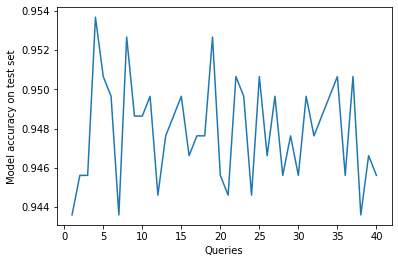

In [12]:
with warnings.catch_warnings(record="True"):
  # Split test set into simulation set and actual test set
  simulation_idx = np.random.choice(len(X_test), int(len(X_test)/2), replace=False)
  test_idx = [i for i in range(len(X_test)) if i not in simulation_idx]
  X_simulation_AL = []
  y_simulation_AL = []
  for idx in simulation_idx:
    X_simulation_AL.append(X_test.iloc[idx]) 
    y_simulation_AL.append(y_test.iloc[idx])

  X_test_AL = []
  y_test_AL = []
  for idx in test_idx:
    X_test_AL.append(X_test.iloc[idx]) 
    y_test_AL.append(y_test.iloc[idx])

  # Start AL loops simulated with a part of the test data
  X_simulation_df = pd.DataFrame(X_simulation_AL)
  y_simulation_df = pd.DataFrame(y_simulation_AL)

  # X_simulation_np = np.array(X_simulation_AL)
  # y_simulation_np = np.array(y_simulation_AL)

  # X_simulation_df = X_simulation_df.reset_index(drop=True)
  for query_size in query_sizes:
    model_accuracies = []
    feed_to_learner = []

    preset_batch = partial(uncertainty_batch_sampling, n_instances=query_size)
    learner = ActiveLearner(
      estimator=RandomForestClassifier(),
      X_training=X_train_new, y_training=y_train,
      query_strategy=preset_batch
    )

    num_of_queries = int(len(X_simulation_df)/query_size)
    print(f"\n>>>>>>>>>>>>>> [NEW ITERATION WITH NEXT QUERY SIZE] The total number of queries: {num_of_queries} <<<<<<<<<<<<<<\n")
    
    unqueried_score = learner.score(X_test_AL, y_test_AL)
    model_accuracies.append(unqueried_score)
    print(f"[INITIAL] Unqueried score before the AL teaching: {unqueried_score}")

    for i in range(num_of_queries):
      print(f"\n*********** QUERY {i+1} ***********\n")
      print(f"Length of simulation set in query {i+1} is: {len(X_simulation_df)}")
      query_idx, query_inst = learner.query(np.array(X_simulation_df))
      print(f"Nodes returned for query in iteration 1: {query_idx}")
      learner.teach(X = X_simulation_df.iloc[query_idx], y = y_simulation_df.iloc[query_idx])
      feed_to_learner += list(query_idx)

      # delete queries that have been looped back into the model
      X_simulation_df = X_simulation_df.drop(X_simulation_df.index[query_idx])
      y_simulation_df = y_simulation_df.drop(y_simulation_df.index[query_idx])

      # learner.teach(X = pd.Series(X_simulation_np[idx]), y = y_simulation_np[idx])

      # X_simulation_np = np.delete(X_simulation_np, query_index, axis=0)
      # y_simulation_np = np.delete(y_simulation_np, query_index)

      # Calculate and report our model's accuracy.
      model_accuracy = learner.score(X_test_AL, y_test_AL)
      model_accuracies.append(model_accuracy)
      print(f"\n[INTERMEDIATE] Accuracy after query {i+1}: {model_accuracy:0.4f}")

  print(f"\n[FINAL] Accuracy after query {num_of_queries}: {model_accuracies[-1]:0.4f}")
  print(f"\n[FINAL-HIGHEST] OPTIMAL Accuracy obtained: {max(model_accuracies):0.4f}")
  print(f"\n[FINAL ACCURACY LIST]: {model_accuracies}")
  print(f"\n[FINAL FEED TO LEARNER LIST]: {len(feed_to_learner)}, {feed_to_learner}")
  plt.plot([1] + [i+1 for i in range(1, num_of_queries + 1)], model_accuracies)
  plt.xlabel("Queries")
  plt.ylabel("Model accuracy on test set")
  plt.show()